In [13]:
from rdflib import Graph, Namespace, URIRef, RDF, RDFS, OWL
NELL = Namespace("http://nell-995.org/")
g = Graph()
g.bind("nell", NELL)
g.bind("owl", OWL)
g.bind("rdfs", RDFS)
SPORT_RELATIONS = {
    "athleteplayssport",
    "athleteplayssport_inv",
    "athleteplaysforteam",
    "athleteplaysforteam_inv",
    "athleteplayssportsteamposition",
    "athleteplayssportsteamposition_inv",
    "athleteflyouttosportsteamposition",
    "athleteflyouttosportsteamposition_inv",
}
def is_sport_relation(rel):
    rel = rel.lower()
    return rel in SPORT_RELATIONS
# Define a generic entity class
g.add((NELL.Entity, RDF.type, OWL.Class))

# Helper function for URI cleaning
def clean_uri(text):
    return text.replace("concept:", "").replace(":", "_").replace("/", "_")

path = "kb_env_rl.txt"
i=0
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:
            subject, objs, relation = parts  
           
            s = URIRef(clean_uri(subject))
            r = URIRef(clean_uri(relation))         
            o = URIRef(clean_uri(objs))
            if not is_sport_relation(r):
                continue
            # Add the triple itself
            g.add((s, r, o))

            # Add class and property semantics
            g.add((r, RDF.type, OWL.ObjectProperty))
            g.add((s, RDF.type, NELL.Entity))
            g.add((o, RDF.type, NELL.Entity))
            i+=1


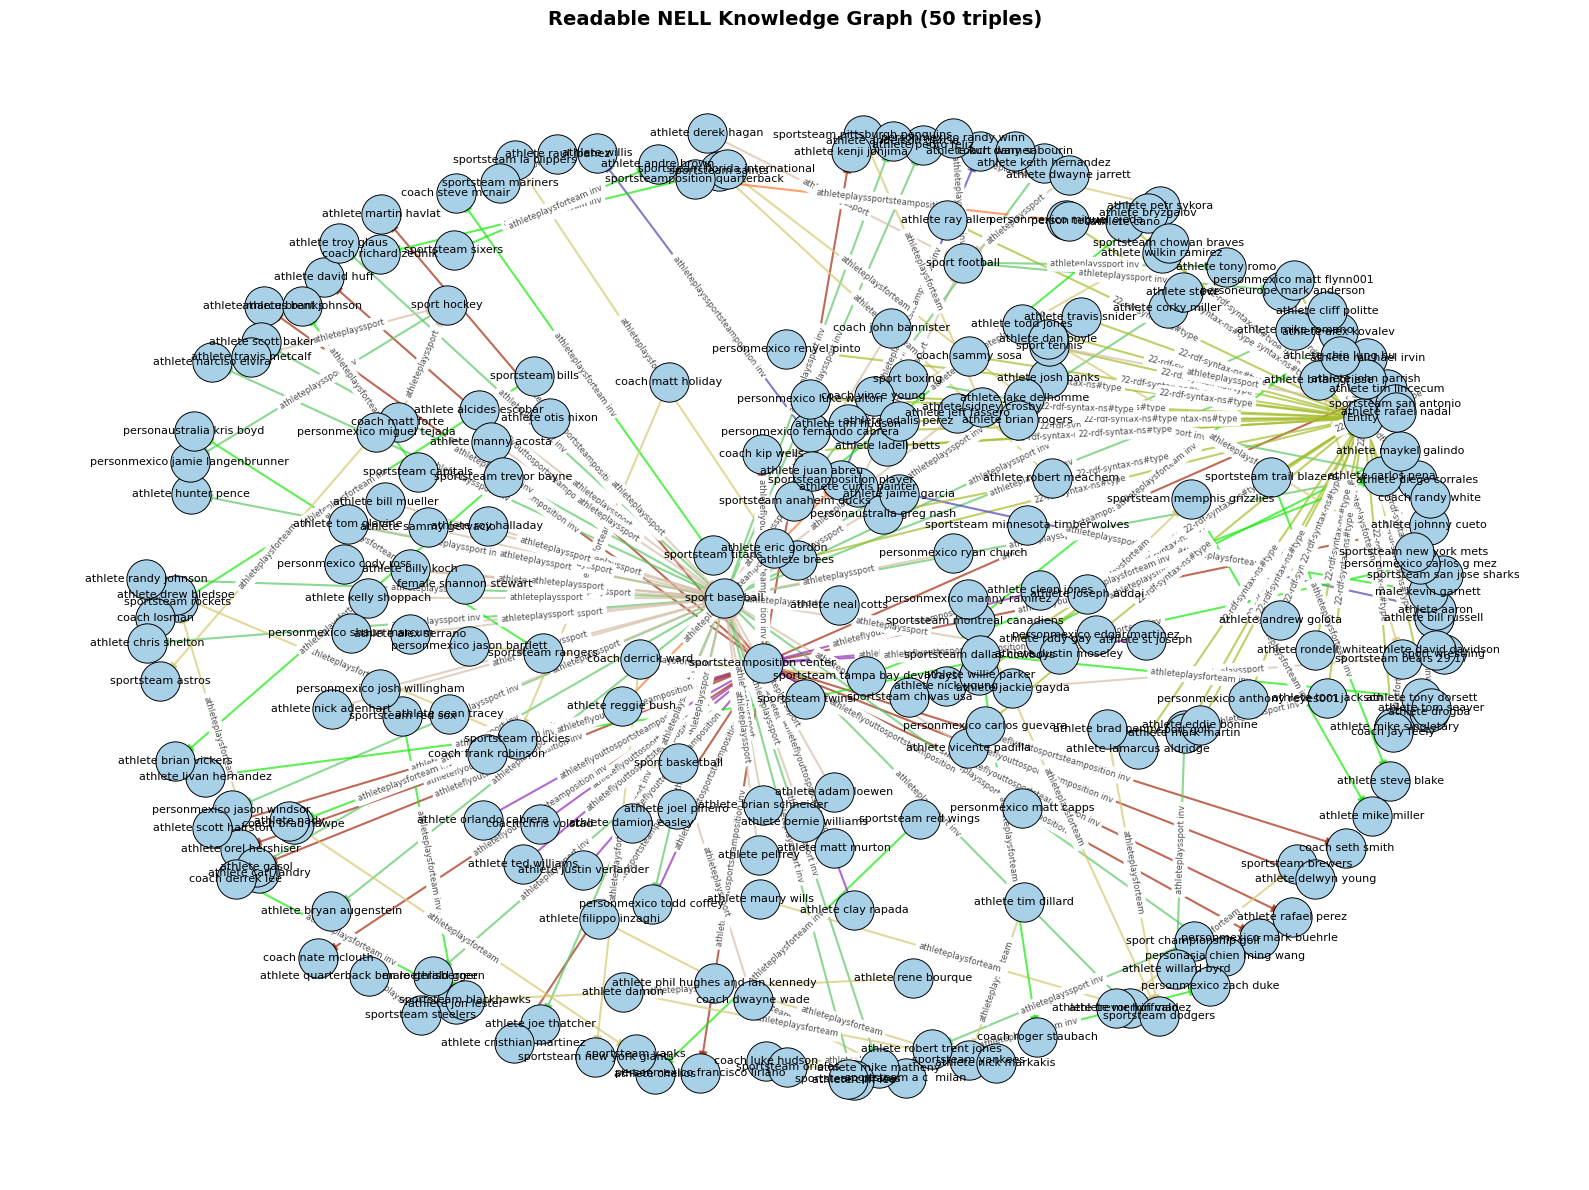

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Function to clean up labels for readability
def short_label(uri):
    label = uri.split("/")[-1]  # get last part of the URI
    label = label.replace("concept_", "").replace("_", " ")
    return label

# Sample a small portion for clarity
subgraph = list(g)[:200]
G = nx.DiGraph()

for s, p, o in subgraph:
    G.add_edge(str(s), str(o), label=str(p))

# Position nodes with a force-directed layout
pos = nx.spring_layout(G, k=0.7, iterations=100, seed=42)

# Prepare label maps
node_labels = {n: short_label(n) for n in G.nodes()}
edge_labels = {(s, o): short_label(p) for s, o, p in G.edges(data='label')}

# Assign colors by relation type
relations = list(set(edge_labels.values()))
color_map = {r: (random.random(), random.random(), random.random()) for r in relations}
edge_colors = [color_map[edge_labels[(u, v)]] for u, v in G.edges()]

# Draw the graph
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#a8d0e6", edgecolors="black", linewidths=0.7)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowsize=12, width=1.5, alpha=0.7)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.5, alpha=0.7)

plt.title("Readable NELL Knowledge Graph (50 triples)", fontsize=14, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()


In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import spacy

nlp = spacy.load("en_core_web_sm")
def entidades(artigo):
    doc = nlp(artigo)
    return [(e.text, e.label_) for e in doc.ents]
artigo=artigo = """
concept_scientist_darwin bookwriter_inv concept_book_origin
"""

def triplets(artigo):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    artigo = artigo.strip()
    current = 'x'
    for token in artigo.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 3,
}
model_inputs = tokenizer(artigo, max_length=256, padding=True, truncation=True, return_tensors = 'pt')

# Generate
generated_tokens = model.generate(
    model_inputs["input_ids"].to(model.device),
    attention_mask=model_inputs["attention_mask"].to(model.device),
    **gen_kwargs,
)


decoded = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

triples = triplets(decoded[0])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def triplo(g, head, relation, tail):
    s = (head)
    p = (relation)
    o = (tail)
    return (s, p, o) in g
for t in triples:
    head = t["head"]
    rel = t["type"]
    tail = t["tail"]

    exists = triplo(g, head, rel, tail)

    if exists:
        print(f"✔ Triplo ENCONTRADO no grafo: ({head}, {rel}, {tail})")
    else:
        print(f"✘ Triplo NÃO encontrado no grafo: ({head}, {rel}, {tail})")


✘ Triplo NÃO encontrado no grafo: (bookwriter, subclass of, author)
